In [1]:
from src.OPFInterface import OPFClassifier
from functools import cmp_to_key
import pandas as pd
import numpy as np
from os import listdir
from src.utils import error, read_df, euclidean_distance_classify
from jupyter_dash import JupyterDash
from dash import dcc, html, Input, Output, no_update
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

/mnt/c/Users/AndreFakhoury/Documents/GitHub/time-series-opf/venv/lib/python3.8/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/c/Users/AndreFakhoury/Documents/GitHub/time-series-opf/venv/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/c/Users/AndreFakhoury/Documents/GitHub/time-series-opf/venv/lib/python3.8/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/c/Users/AndreFakhoury/Documents/GitHub/time-series-opf/venv/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type 

In [2]:
X, y, X_test, y_test, df_errors = read_df("MelbournePedestrian")

In [3]:
# from sklearn.manifold import MDS
# embedding = MDS(n_components=2)
# X_t = embedding.fit_transform(X)

In [4]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda_clf = LDA(n_components=2)
X_t = lda_clf.fit_transform(X, y)

In [7]:
palette = sns.color_palette("tab20")

fig = go.Figure(data=[
    go.Scatter(
        x=X_t[:,0],
        y=X_t[:,1],
        mode="markers",
        marker=dict(
            colorscale='viridis',
            color=[f'rgb{palette[y[num]%len(palette)]}' for num in range(len(X))],
            line={"color": "#444"},
            reversescale=True,
            sizeref=45,
            sizemode="diameter",
            opacity=0.6,
        )
    )
])


# turn off native plotly.js hover effects - make sure to use
# hoverinfo="none" rather than "skip" which also halts events.
fig.update_traces(hoverinfo="none", hovertemplate=None)

fig.update_layout(
    plot_bgcolor='rgba(255,255,255,0.1)'
)

app = JupyterDash(__name__)

app.layout = html.Div([
    dcc.Graph(id="graph", figure=fig, clear_on_unhover=True),
    dcc.Tooltip(id="graph-tooltip"),
])


@app.callback(
    Output("graph-tooltip", "show"),
    Output("graph-tooltip", "bbox"),
    Output("graph-tooltip", "children"),
    Input("graph", "hoverData"),
)
def display_hover(hoverData):
    if hoverData is None:
        return False, no_update, no_update

    # demo only shows the first point, but other points may also be available
    pt = hoverData["points"][0]
    bbox = pt["bbox"]
    num = pt["pointNumber"]
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=np.array(range(len(X[num]))), y=X[num],
        line_color=f'rgb{palette[y[num]%len(palette)]}',
    ))
    fig.update_yaxes(visible=False, showticklabels=False)
    fig.update_xaxes(visible=False, showticklabels=False)
    fig.update_layout(
        showlegend=False,
        plot_bgcolor="white",
        margin=dict(t=10,l=10,b=10,r=10),
        height=100,
        width=120
    )

    children = [
        html.Div(children=[
            html.H4(f"#{num}"),
            html.Div(f"Label {y[num]}"),
            dcc.Graph(figure=fig)
        ],
        style={'width': '120px', 'white-space': 'normal'})
    ]

    return True, bbox, children


if __name__ == "__main__":
    app.run_server(debug=True, mode='inline')

/mnt/c/Users/AndreFakhoury/Documents/GitHub/time-series-opf/venv/lib/python3.8/site-packages/jupyter_dash/jupyter_app.py:139: UserWarning:

The 'environ['werkzeug.server.shutdown']' function is deprecated and will be removed in Werkzeug 2.1.



### Trees

In [3]:
from collections import defaultdict
from operator import itemgetter
import heapq

"""Union Find structure with Path Compression + Merge by Size"""
class DSU:
    def __init__(self, n):
        self.par = np.arange(n)
        self.siz = np.ones(n)
        
    def find(self, x):
        if self.par[x] == x:
            return x
        self.par[x] = self.find(self.par[x])
        return self.par[x]
    
    def same(self, u, v):
        return self.find(u) == self.find(v)

    def merge(self, u, v):
        u = self.find(u)
        v = self.find(v)
        if u == v:
            return
        if self.siz[u] > self.siz[v]:
            u, v = v, u
        self.par[u] = v
        self.siz[v] += self.siz[u]

"""Optimum Path Forest Classifier"""
class OptimumPathForestClassifier:    
    def __init__(self, cost='euclidean-distance'):
        available_cost_functions = {
            'euclidean-distance': lambda x, y: np.linalg.norm(x - y),
            'manhattan-distance': lambda x, y: np.sum(np.abs(x - y)),
            'dtw-distance': lambda x, y: dtw.distance_fast(x, y, window=100, use_pruning=True)
        }
        assert cost in available_cost_functions.keys(),\
            f"Invalid cost function. Should be one of {available_cost_functions.keys()}"
        self.F = available_cost_functions[cost]
    
    def fit(self, X_, Y_):
        n = len(Y_)
        self.X = np.array(X_, copy=True, dtype=float)
        self.label = np.ones(n, dtype=int) * -1
        Y = np.array(Y_, copy=True, dtype=int)
        
        # First of all, builds the graph
        self.adj = defaultdict(list)
        self.edges = []
        for u in range(n):
            self.adj[u] = [(v, self.F(self.X[u], self.X[v])) for v in range(n)]
            self.edges += [(w, u, v) for v, w in self.adj[u]]
        
        # Runs MST (Kruskal) to choose PROTOTYPES (seed vertices)
        self.prototypes = []        
        self.edges.sort()
        dsu = DSU(n)
        for w, u, v in self.edges:
            if not dsu.same(u, v):
                dsu.merge(u, v)
                if Y[u] != Y[v]:
                    self.prototypes += [u, v]
        self.prototypes = np.unique(self.prototypes)
        
        # Run multisourced dijkstra on prototypes to get the cost
        self.cost = np.ones(n) * np.inf
        self.cost[self.prototypes] = 0
        self.label[self.prototypes] = Y[self.prototypes]
        self.parent = np.ones(n, dtype=int) * -1
        
        pq = [[0., u] for u in self.prototypes]
        heapq.heapify(pq)
        while pq:
            u_w, u = heapq.heappop(pq)
            if self.cost[u] < u_w:
                continue
            for v, w in self.adj[u]:
                if self.cost[v] > max(u_w, w):
                    self.cost[v] = max(u_w, w)
                    self.label[v] = self.label[u]
                    self.parent[v] = u
                    heapq.heappush(pq, [self.cost[v], v])
        self.ordered_nodes = [(u, self.cost[u]) for u in range(n)]
        self.ordered_nodes.sort(key=itemgetter(1))
                    
    def _classify_one_vertex(self, x):
        best_index, best_cost = self.ordered_nodes[0]
        best_cost = max(best_cost, self.F(self.X[best_index], x))
        best_label = self.label[best_index]
        
        for i in range(1, len(self.X)):
            cur_index, cur_cost = self.ordered_nodes[i]
            if cur_cost > best_cost:
                break
            cur_cost = max(cur_cost, self.F(self.X[cur_index], x))
            cur_label = self.label[cur_index]
            if cur_cost < best_cost:
                best_index, best_cost, best_label = cur_index, cur_cost, cur_label
        return best_label
    
    def classify(self, X_):
        X_train = np.array(X_, copy=True)
        return [self._classify_one_vertex(x) for x in X_train]

X, y, X_test, y_test, df_errors = read_df("InsectEPGRegularTrain")
opf = OptimumPathForestClassifier()
opf.fit(X, y)

In [5]:
palette = sns.color_palette("tab20")

def plot_graph(G, color=[], title="", text=""):
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = G.nodes[edge[0]]['pos']
        x1, y1 = G.nodes[edge[1]]['pos']
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    node_x = []
    node_y = []
    for node in G.nodes():
        x, y = G.nodes[node]['pos']
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            # colorscale options
            #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
            #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
            #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
            colorscale='YlGnBu',
            reversescale=True,
            color=color,
            size=10,
            line_width=2))
    fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title=title,
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text=text,
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
            )
    return fig

In [33]:
X, y, X_test, y_test, df_errors = read_df("InsectEPGRegularTrain")
opf = OptimumPathForestClassifier()
opf.fit(X, y)

from sklearn.manifold import MDS
embedding = MDS(n_components=2)
X_t = embedding.fit_transform(X)

import networkx as nx
G = nx.Graph(directed=True)
G.add_nodes_from(list(range(len(X))))
G.add_weighted_edges_from([(opf.parent[u], u, opf.F(X[u], X[opf.parent[u]])) for u in range(len(X)) if opf.parent[u] != -1])
nx.set_node_attributes(G, {u: X_t[u] for u in range(len(X))}, "pos")

fig = plot_graph(G,
    color=[f'rgb{palette[y[u]%len(palette)]}' for u in range(len(X))],
    title=f"OPF: {round(error(opf.classify(X_test), y_test), 3)} vs 1NN: {df_errors['ED']}"
)

# turn off native plotly.js hover effects - make sure to use
# hoverinfo="none" rather than "skip" which also halts events.
fig.update_traces(hoverinfo="none", hovertemplate=None)

fig.update_layout(
    plot_bgcolor='rgba(255,255,255,0.1)'
)

app = JupyterDash(__name__)

app.layout = html.Div([
    dcc.Graph(id="graph", figure=fig, clear_on_unhover=True),
    dcc.Tooltip(id="graph-tooltip"),
])


@app.callback(
    Output("graph-tooltip", "show"),
    Output("graph-tooltip", "bbox"),
    Output("graph-tooltip", "children"),
    Input("graph", "hoverData"),
)
def display_hover(hoverData):
    if hoverData is None:
        return False, no_update, no_update

    # demo only shows the first point, but other points may also be available
    pt = hoverData["points"][0]
    if pt["curveNumber"] != 1: # not a vertex
        return False, no_update, no_update
    
    bbox = pt["bbox"]
    num = pt["pointNumber"]
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=np.array(range(len(X[num]))), y=X[num],
        line_color=f'rgb{palette[y[num]%len(palette)]}',
    ))
    fig.update_yaxes(visible=False, showticklabels=False)
    fig.update_xaxes(visible=False, showticklabels=False)
    fig.update_layout(
        showlegend=False,
        plot_bgcolor="white",
        margin=dict(t=10,l=10,b=10,r=10),
        height=100,
        width=120
    )

    children = [
        html.Div(children=[
            html.H4(f"#{num}"),
            html.Div(f"Label {y[num]}"),
            dcc.Graph(figure=fig)
        ],
        style={'width': '120px', 'white-space': 'normal'})
    ]

    return True, bbox, children


if __name__ == "__main__":
    app.run_server(debug=True, mode='inline')

/mnt/c/Users/AndreFakhoury/Documents/GitHub/time-series-opf/venv/lib/python3.8/site-packages/jupyter_dash/jupyter_app.py:139: UserWarning:

The 'environ['werkzeug.server.shutdown']' function is deprecated and will be removed in Werkzeug 2.1.



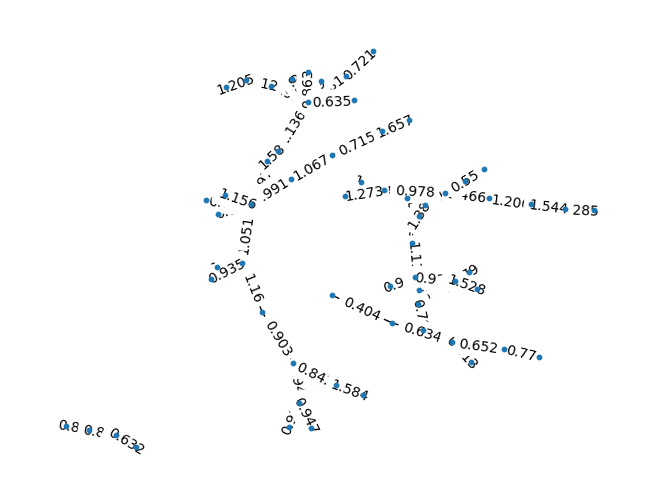

In [21]:
X, y, X_test, y_test, df_errors = read_df("InsectEPGRegularTrain")
opf = OptimumPathForestClassifier()
opf.fit(X, y)

from sklearn.manifold import MDS
embedding = MDS(n_components=2)
X_t = embedding.fit_transform(X)

import networkx as nx
G = nx.Graph(directed=True)
G.add_nodes_from(list(range(len(X))))
G.add_weighted_edges_from([(opf.parent[u], u, round(opf.F(X[u], X[opf.parent[u]]), 3)) for u in range(len(X)) if opf.parent[u] != -1])
nx.set_node_attributes(G, {u: X_t[u] for u in range(len(X))}, "pos")

pos=nx.spring_layout(G)
nx.draw(G, node_size=10, pos=pos)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels);

# fig = plot_graph(G,
#     color=[f'rgb{palette[y[u]%len(palette)]}' for u in range(len(X))],
#     title=f"OPF: {round(error(opf.classify(X_test), y_test), 3)} vs 1NN: {df_errors['ED']}"
# )
# fig.show()